## EE 782: Advanced Topics in Machine Learning
### **Assignment 2:** Metric Learning & Generative AI
> **NAME:** Munish Monga

> **ROLL NO:** 22M2153

> [Github Repo Link](https://github.com/munish30monga/Metric_Learning-Generative_AI)

### Table of Contents:
- [Introduction](#introduction)
- [Importing Libraries](#importing-libraries)
- [Hyperparameters](#hyperparameters)
- [References](#references)

### Introduction <a id="introduction"></a>
**PART A: Metric Learning using Siamese Network**
> We have to train a Siamese Network on Labeled Faces in the Wild (LFW) Dataset


**PART B: Generative AI using GANs**
> We have to train a generative model for generating face images, using a GAN.

### Importing Libraries <a id="importing-libraries"></a>

In [104]:
import pathlib as pl                                            # for path handling
import matplotlib.pyplot as plt                                 # for plotting
from PIL import Image                                           # for image handling
from sklearn.model_selection import train_test_split            # for splitting data
import random                                                   # for random number generation
import torch                                                    # for deep learning functionality
import numpy as np                                              # for numerical operations  
import matplotlib.pyplot as plt                                 # for plotting 
import torch.nn as nn                                           # for neural network functionality
import torch.nn.functional as F                                 # for neural network functionality        
import torch                                                    # for deep learning functionality
from torchvision import transforms                              # for image transformations
from torchvision.transforms import CenterCrop                   # for cropping images
from torch.utils.data import Dataset, DataLoader                # for dataset handling
import torchvision.models as models                             # for getting pretrained models
from tqdm import tqdm                                           # for progress bar
from sklearn.metrics import accuracy_score, classification_report

### Hyperparameters <a id="hyperparameters"></a>

In [89]:
batch_size = 64                                                     # batch size for training
random_seed = 42                                                    # for reproducibility
random.seed(random_seed)                                            # set random seed
device = 'cuda' if torch.cuda.is_available() else 'cpu'             # set device to cuda if available
epochs = 5                                                          # number of epochs to train
learning_rate = 0.01                                                # learning rate for optimizer
base_model = "resnet18" # "resnet50"                                # base model for transfer learning
similarity_metric = "euclidean" # "cosine"                          # similarity metric for Siamese network
loss_function = "cross_entropy" # "hinge"                           # loss function for Siamese network
margin = 2                                                          # margin for contrastive loss

## **PART A:** Metric Learning using Siamese Network <a id="part-a"></a>
### Downloading Dataset
> <font color="gray">Q1. Download labeled faces in the wild (LFW) dataset</font>

LFW Dataset was downloaded and extracted into the following path: `./dataset/lfw/`

### Exploring Dataset <a id="exploring-dataset"></a>

In [37]:
data_dir = pl.Path('./dataset/lfw/')     # Setting path to the data directory
persons_dirs = [d for d in data_dir.iterdir() if d.is_dir()] # List all subdirectories (each directory corresponds to a person)
all_persons_dict = {person_dir.name: len(list(person_dir.glob("*.jpg"))) for person_dir in persons_dirs} # Create a dictionary of all persons and the number of images they have
all_persons = list(all_persons_dict.keys())             # List of all persons

In [38]:
print(f"Total number of persons: {len(all_persons)}")  # Print the number of persons
for i, (person, num_images) in enumerate(all_persons_dict.items()):  # Loop through all persons dictionary
    if i >= 10:                     # Break the loop after printing 10 persons
        break
    print(f"{i+1}.{person}: {num_images}")  # Print the number of images for each person

Total number of persons: 5749
1.Demi_Moore: 4
2.Glen_Sather: 1
3.Carlos_De_Abreu: 1
4.Stacy_Dragila: 2
5.Donald_Keyser: 1
6.Megan_Mullally: 3
7.Roh_Moo-hyun: 32
8.Barbora_Strycova: 1
9.Peter_Camejo: 1
10.Bryan_Thomas: 1


> <font color="gray">Q2. Get the number of persons who have more than one image</font>

In [39]:
persons_with_mul_imgs_dict = {person: num_images for person, num_images in all_persons_dict.items() if num_images > 1}
print(f"Number of persons with more than one image: {len(persons_with_mul_imgs_dict)}")
for i, (person, num_images) in enumerate(persons_with_mul_imgs_dict.items()):
    if i >= 10:
        break
    print(f"{i+1}.{person}: {num_images}")

Number of persons with more than one image: 1680
1.Demi_Moore: 4
2.Stacy_Dragila: 2
3.Megan_Mullally: 3
4.Roh_Moo-hyun: 32
5.Erin_Runnion: 4
6.Diana_Taurasi: 2
7.Vaclav_Havel: 9
8.Tom_Watson: 3
9.John_Mayer: 3
10.Raghad_Saddam_Hussein: 2


In [40]:
def visualize(persons_dict):
    """
    Visualizes a grid of persons' images.
    """
    # Display in an 8x8 grid
    fig, axes = plt.subplots(8, 8, figsize=(15, 15))
    
    grid_position = 0  # Counter for the position in the 8x8 grid
    
    for person, count in persons_dict.items():
        if grid_position >= 64:  # Break after 64 cells
            break
        person_dir = data_dir / person
        images = list(person_dir.glob("*.jpg"))
        for img_path in images:
            if grid_position >= 64:  # Break after 64 cells
                break
            image = Image.open(img_path)
            image = image.resize((64, 64))
            row, col = divmod(grid_position, 8)
            axes[row, col].imshow(image)
            axes[row, col].axis('off')
            axes[row, col].set_title(f"{person}")
            grid_position += 1

    plt.tight_layout()
    plt.show()

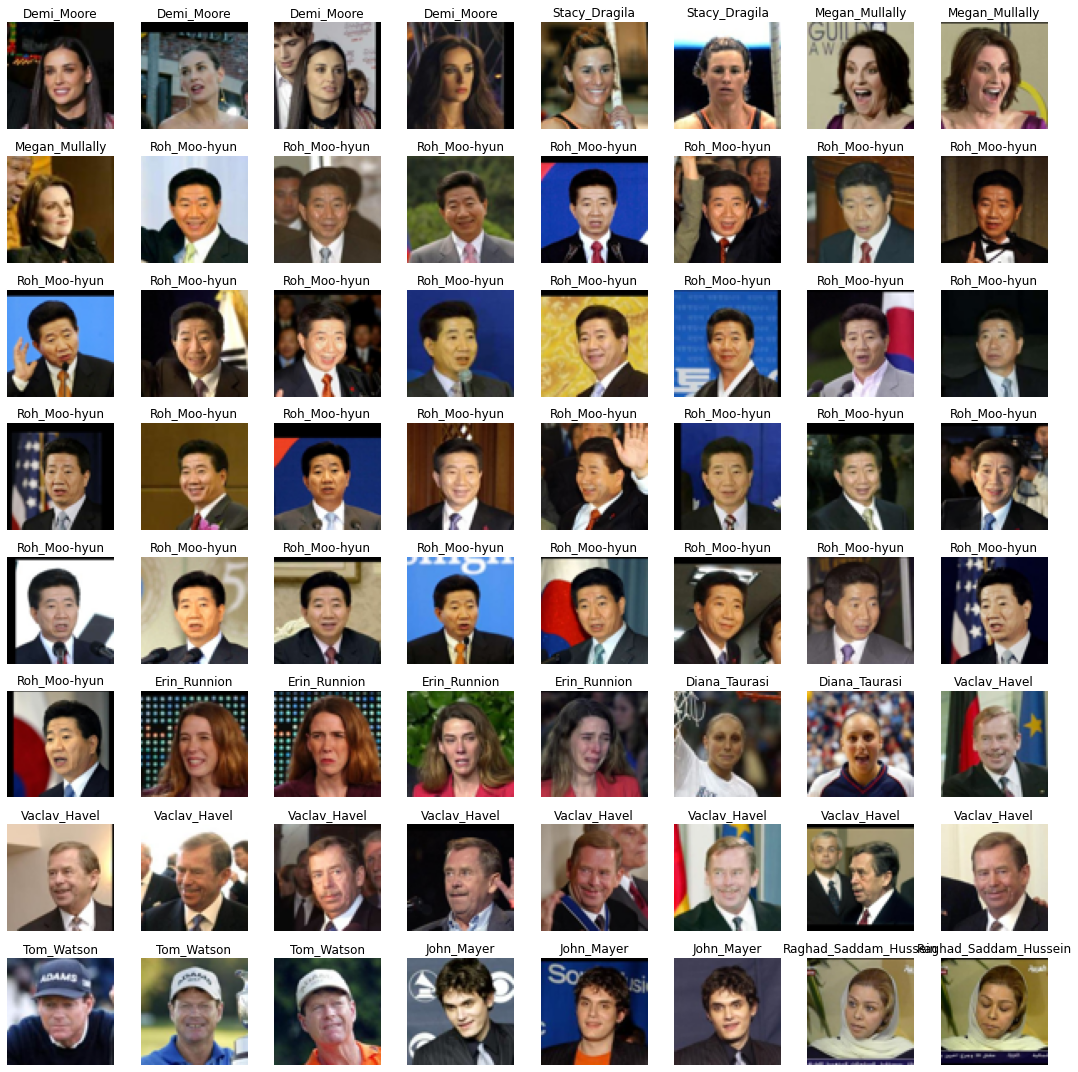

In [41]:
visualize(persons_with_mul_imgs_dict)

### Train-Test Split <a id="train-test-split"></a>
> <font color="gray">Q3. Split into training, validation, and testing by person (not by image)</font>

In [42]:
def split_data(persons_dict):
    """
    Split persons data for training a Siamese network.
    
    Args:
    - persons_dict (dict): Dictionary with person names as keys and the number of images as values.

    Returns:
    - train_persons_dict (dict): Dictionary for training set.
    - valid_persons_dict (dict): Dictionary for validation set.
    - test_persons_dict (dict): Dictionary for test set.
    """
    person_names = list(persons_dict.keys())
    
    # Split into 70% for training and 30% for validation + test
    train_persons, remaining_persons = train_test_split(person_names, test_size=0.3, random_state=42)
    
    # Split the remaining 30% equally into validation and test sets
    valid_persons, test_persons = train_test_split(remaining_persons, test_size=0.5, random_state=42)
    
    # Create dictionaries for each set
    train_persons_dict = {person: persons_dict[person] for person in train_persons}
    valid_persons_dict = {person: persons_dict[person] for person in valid_persons}
    test_persons_dict = {person: persons_dict[person] for person in test_persons}
    
    return train_persons_dict, valid_persons_dict, test_persons_dict

In [43]:
train_persons_dict, valid_persons_dict, test_persons_dict = split_data(persons_with_mul_imgs_dict)
print(f"Number of persons in Training Set: {len(train_persons_dict)}")
print(f"Number of persons in Validation Set {len(valid_persons_dict)}")
print(f"Number of persons in Test Set {len(test_persons_dict)}")

Number of persons in Training Set: 1176
Number of persons in Validation Set 252
Number of persons in Test Set 252


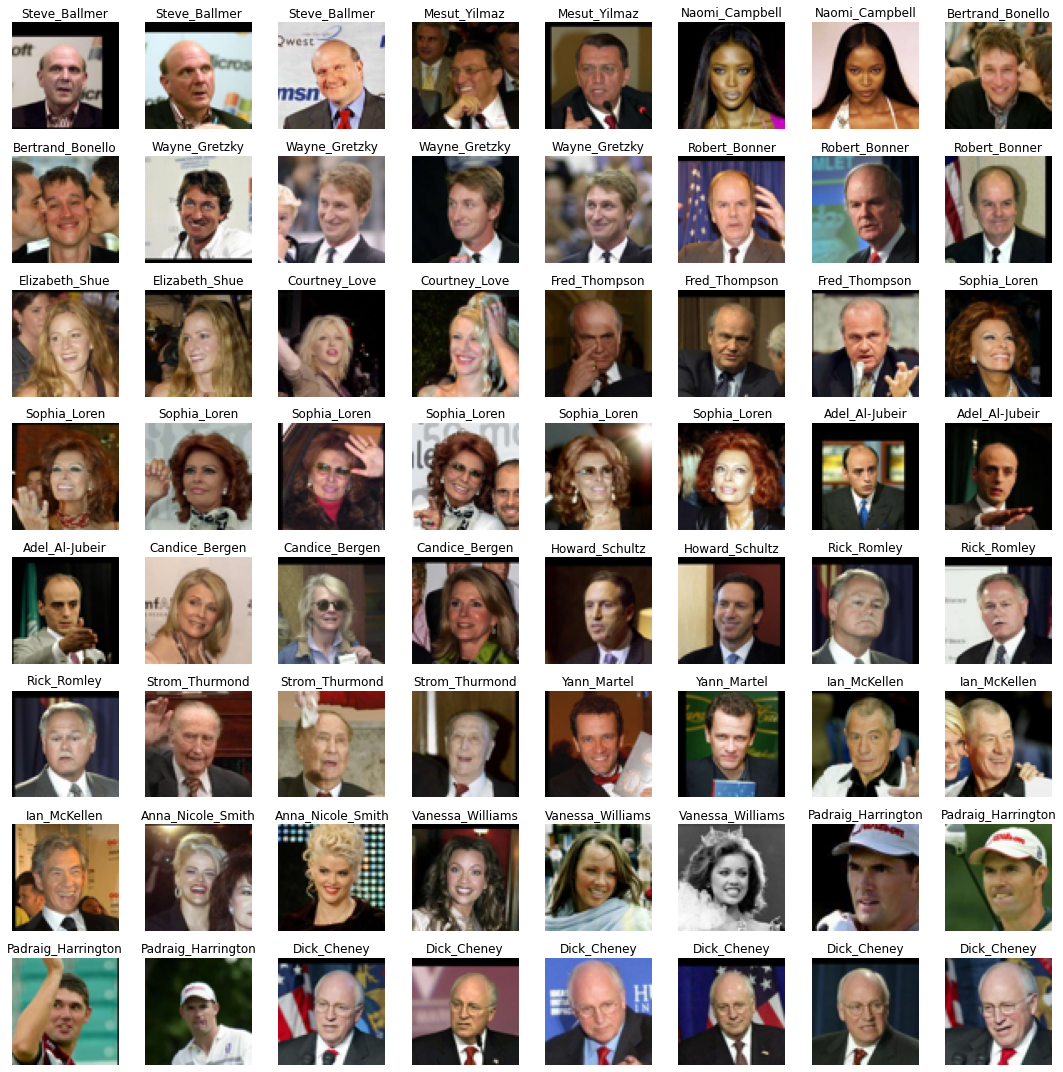

In [44]:
visualize(test_persons_dict)

In [45]:
def generate_pairs(persons_dict):
    X, Y = [], []

    person_names = list(persons_dict.keys())
    for idx, person in enumerate(person_names):
        person_dir = data_dir / person
        images = list(person_dir.glob("*.jpg"))

        # Generate positive pairs
        if len(images) >= 2:
            pair = random.sample(images, 2)
            X.append(pair)
            Y.append(1.0)  # Same person

        # Generate negative pairs
        other_person = random.choice(person_names[:idx] + person_names[idx+1:])
        other_person_dir = data_dir / other_person
        other_person_images = list(other_person_dir.glob("*.jpg"))

        if len(images) > 0 and len(other_person_images) > 0:
            img1 = random.choice(images)
            img2 = random.choice(other_person_images)
            X.append([img1, img2])
            Y.append(0.0)  # Different persons

    return X, Y

**Positive Pairs Generation**:
   - For each person in the list of `person_names`, the function identifies the directory specific to that person (`person_dir`).
   - It then retrieves all image paths for that person using the `glob` method.
   - If there are at least 2 images for that person (checked using `if len(images) >= 2:`), it randomly selects 2 distinct images from the available images of that person. This is achieved using `random.sample(images, 2)`.
   - This pair of images is appended to the `X` list.
   - Since this is a positive pair (both images are of the same person), a label of `1.0` is appended to the `y` list.

**Negative Pairs Generation**:
   - For each person in the list of `person_names`, the function selects another person (distinct from the current person) using the line: `other_person = random.choice(person_names[:idx] + person_names[idx+1:])`. This ensures that the `other_person` is not the current person.
   - It then identifies the directory specific to this `other_person` (`other_person_dir`) and retrieves all image paths for that other person.
   - A negative pair is created by randomly selecting one image from the current person and one image from the `other_person`.
   - This pair of images is appended to the `X` list.
   - Since this is a negative pair (the images are of two different persons), a label of `0.0` is appended to the `y` list.

For each person:
  - If they have at least two images, one positive pair is generated.
  - Regardless of the number of their images, one negative pair is generated (using one image of the current person and one image of a randomly selected different person). 


In [46]:
X, Y = generate_pairs(persons_with_mul_imgs_dict)
print(f"X[0][0]: {X[0][0]}")
print(f"X[0][1]: {X[0][1]}")  # contains the image paths for the pair
print(f"Y[0]: {Y[0]}")        # contains the label for the pair

X[0][0]: dataset/lfw/Demi_Moore/Demi_Moore_0001.jpg
X[0][1]: dataset/lfw/Demi_Moore/Demi_Moore_0003.jpg
Y[0]: 1.0


In [47]:
def visualize_pairs(X, Y):
    """
    Visualizes pairs of images from X along with their label from Y.

    Args:
    - X (list): List of image pairs.
    - Y (list): List of labels.
    """
    fig, axes = plt.subplots(4, 4, figsize=(15, 5*4))
    
    pos_idx = [i for i, label in enumerate(Y) if label == 1.0]
    neg_idx = [i for i, label in enumerate(Y) if label == 0.0]

    for row in range(4):
        # Display positive pairs
        img_path1, img_path2 = X[pos_idx[row]]
        image1 = Image.open(img_path1)
        image2 = Image.open(img_path2)
        person1_name = img_path1.parent.name  # Assuming the parent directory is the person's name
        person2_name = img_path2.parent.name
        
        axes[row, 0].imshow(np.array(image1), cmap='gray')
        axes[row, 0].axis('off')
        axes[row, 0].set_title(person1_name, fontsize = 18)

        axes[row, 1].imshow(np.array(image2), cmap='gray')
        axes[row, 1].axis('off')
        axes[row, 1].set_title(person2_name, fontsize = 18)

        # Display negative pairs
        img_path1, img_path2 = X[neg_idx[row]]
        image1 = Image.open(img_path1)
        image2 = Image.open(img_path2)
        person1_name = img_path1.parent.name  # Assuming the parent directory is the person's name
        person2_name = img_path2.parent.name

        axes[row, 2].imshow(np.array(image1), cmap='gray')
        axes[row, 2].axis('off')
        axes[row, 2].set_title(person1_name, fontsize = 18)

        axes[row, 3].imshow(np.array(image2), cmap='gray')
        axes[row, 3].axis('off')
        axes[row, 3].set_title(person2_name, fontsize = 18)

    # Setting main titles for Positive and Negative pairs
    fig.text(0.25, 1, 'Positive Pairs', ha='center', va='center', fontsize=24)
    fig.text(0.75, 1, 'Negative Pairs', ha='center', va='center', fontsize=24)
    
    plt.tight_layout()
    plt.show()

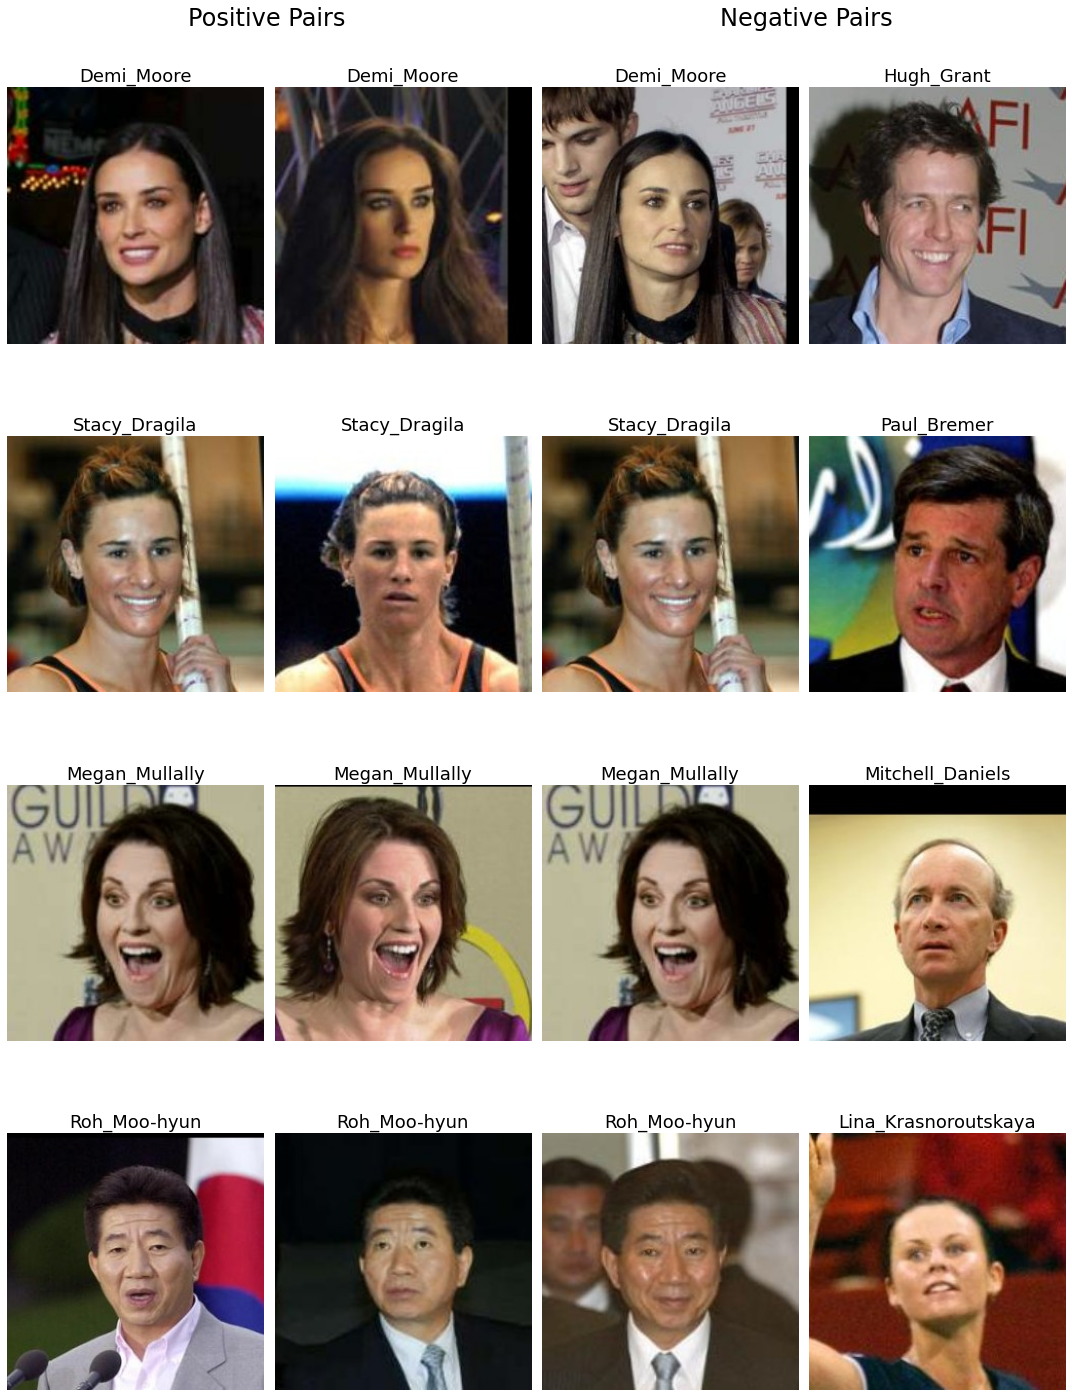

In [48]:
visualize_pairs(X, Y)

### Data Preprocessing <a id="data-preprocessing"></a>
> <font color="gray">Q5. Appropriately crop and resize the images based on your computational resources</font>

In [49]:
def preprocess_data(X):
    """
    Preprocess the images in X by applying a center crop.

    Args:
    - X (list): List of image pairs.

    Returns:
    - X_processed (list): List of preprocessed image pairs.
    """
    crop = CenterCrop(224)      # Crop the center 224x224 pixels of the image    
    X_processed = []

    for pair in X:
        processed_pair = [crop(Image.open(img_path)) for img_path in pair]
        X_processed.append(processed_pair)

    return X_processed

In [50]:
def dict_to_tensors(persons_dict):
    X, Y = generate_pairs(persons_dict)
    
    # Preprocess the data (apply center cropping)
    X = preprocess_data(X)
    
    # Assuming all images have the same dimensions after cropping
    first_image = X[0][0]
    img_width, img_height = first_image.size
    
    X_tensor = torch.empty((len(X), 2, 3, img_height, img_width))  # Shape: (num_pairs, 2, 3, img_height, img_width)

    for i, (img1, img2) in enumerate(X):
        X_tensor[i, 0] = transforms.ToTensor()(img1)  # Convert PIL image to tensor
        X_tensor[i, 1] = transforms.ToTensor()(img2)

    Y_tensor = torch.tensor(Y, dtype=torch.float32)

    return X_tensor, Y_tensor

In [51]:
X_train, Y_train = dict_to_tensors(train_persons_dict)
X_valid, Y_valid = dict_to_tensors(valid_persons_dict)
X_test, Y_test = dict_to_tensors(test_persons_dict)

In [52]:
print(f"X_train shape: {X_train.shape}, Y_train shape: {Y_train.shape}")
print(f"X_valid shape: {X_valid.shape}, Y_valid shape: {Y_valid.shape}")
print(f"X_test shape: {X_test.shape}, Y_test shape: {Y_test.shape}")

X_train shape: torch.Size([2352, 2, 3, 224, 224]), Y_train shape: torch.Size([2352])
X_valid shape: torch.Size([504, 2, 3, 224, 224]), Y_valid shape: torch.Size([504])
X_test shape: torch.Size([504, 2, 3, 224, 224]), Y_test shape: torch.Size([504])


$\text{Shape of } X: (N, 2, C, H, W)$

$\text{Shape of } Y: (N,1)$

where:
- $N$: represents the Number of Image Pairs.
- $2$: represennts a pair (two images)
- $C$: represents the Number of channels in the image (1 as we keep it grayscale)
- $H$: represents the Height of the image
- $W$: represents the Width of the image

### Dataloader <a id="dataloader"></a>

In [53]:
class SiameseDataset(Dataset):
    def __init__(self, X, Y):
        self.X = X
        self.Y = Y

    def __len__(self):
        return len(self.Y)

    def __getitem__(self, index):
        img1 = self.X[index, 0]
        img2 = self.X[index, 1]
        label = self.Y[index]
        return (img1, img2), label

In [54]:
train_dataset = SiameseDataset(X_train, Y_train)
valid_dataset = SiameseDataset(X_valid, Y_valid)
test_dataset = SiameseDataset(X_test, Y_test)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=16, pin_memory=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, num_workers=16, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=16, pin_memory=True)

In [55]:
# Fetching one batch from the DataLoader
for (img1_batch, img2_batch), labels_batch in train_loader:
    # We'll break after the first batch for demonstration
    print(f"Shape of img1_batch: {img1_batch.shape}")       # img1_train batch shape
    print(f"Shape of img2_batch: {img2_batch.shape}")       # img2_train batch shape
    print(f"Shape of labels_batch: {labels_batch.shape}")   # labels_train batch shape
    break

Shape of img1_batch: torch.Size([64, 3, 224, 224])
Shape of img2_batch: torch.Size([64, 3, 224, 224])
Shape of labels_batch: torch.Size([64])


In [77]:
def visualize_batch(dataloader, num_samples=4):
    # Fetch one batch of data
    (img1_batch, img2_batch), labels_batch = next(iter(dataloader))
    
    # Randomly sample indices for visualization
    indices = random.sample(range(len(labels_batch)), num_samples)
    
    fig, axes = plt.subplots(num_samples, 2, figsize=(12, 4 * num_samples))
    
    for i, idx in enumerate(indices):
        # Image 1 from the pair
        img1 = img1_batch[idx].permute(1, 2, 0).numpy()
        # Image 2 from the pair
        img2 = img2_batch[idx].permute(1, 2, 0).numpy()
        
        axes[i, 0].imshow(img1, cmap='gray')
        axes[i, 0].axis('off')
        
        axes[i, 1].imshow(img2, cmap='gray')
        axes[i, 1].axis('off')
        
        if labels_batch[idx] == 1.0:
            label = "Positive Pair"
        else:
            label = "Negative Pair"
        
        # Place the label to the left of the images in vertical fashion
        fig.text(0.1, (num_samples - i - 0.5) / num_samples, label, ha='center', va='center', fontsize=14, rotation=90)
    
    plt.tight_layout()
    plt.show()

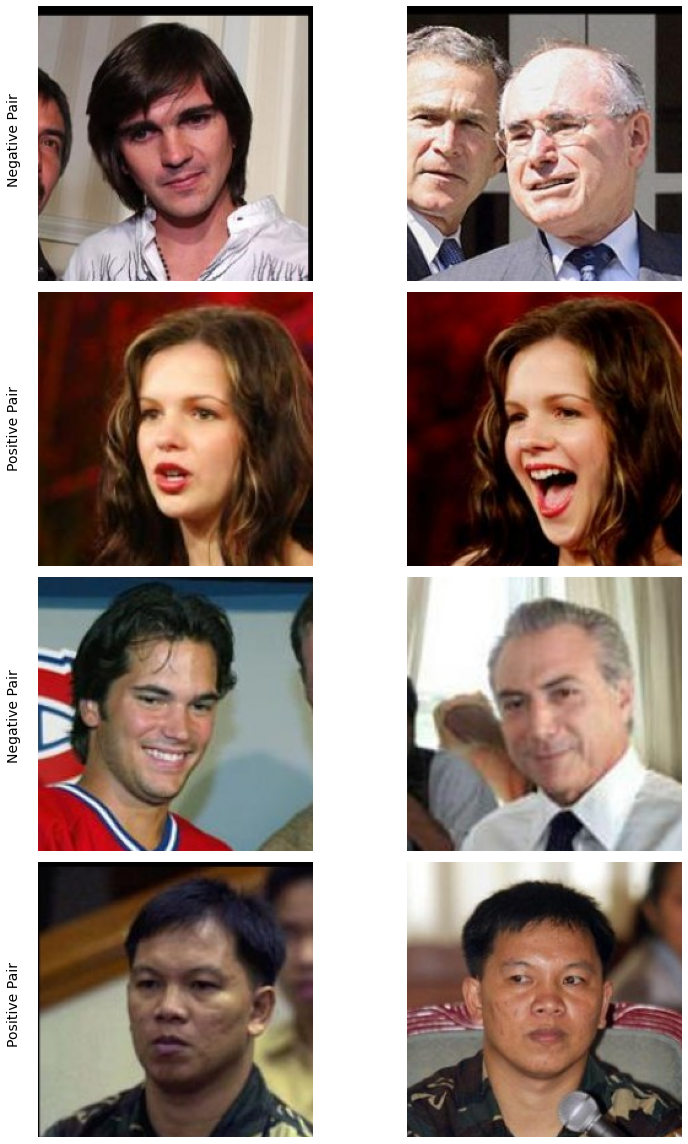

In [78]:
visualize_batch(train_loader)

### Siamase Network <a id="siamase-network"></a>
> <font color="gray">Q6. Setup and train a Siamese network to predict whether a pair of images are of the same person or not using a metric learning scheme</font>

In [129]:
class SiameseNetwork(nn.Module):
    def __init__(self, base_model="resnet18"):
        super(SiameseNetwork, self).__init__()
        
        # Use ResNet-18 as the base model
        if base_model == "resnet18":
            self.base_model = models.resnet18(weights="ResNet18_Weights.DEFAULT")
            # Remove the last fully connected layer (classifier) to get feature representations
            self.base_model = nn.Sequential(*list(self.base_model.children())[:-1])

        
    def forward_one(self, x):
        # Forward pass for one input
        x = self.base_model(x)
        x = x.view(x.size()[0], -1)
        # x = self.projection(x)
        return x

    def forward(self, input1, input2):
        # Forward pass for both inputs
        output1 = self.forward_one(input1)
        output2 = self.forward_one(input2)
        return output1, output2

In [130]:
model = SiameseNetwork(base_model=base_model)
print(model)

SiameseNetwork(
  (base_model): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_s

In [131]:
class ContrastiveLoss(nn.Module):
    def __init__(self, margin=2.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, output1, output2, label):
        euclidean_distance = F.pairwise_distance(output1, output2)
        loss = torch.mean((1-label) * torch.pow(euclidean_distance, 2) +
                          (label) * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2))
        return loss

### Training Loop <a id="training-loop"></a>

In [132]:
def train_model(model, train_loader, valid_loader, num_epochs, learning_rate):
    model = model.to(device)
    
    criterion = ContrastiveLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    
    train_losses, valid_losses = [], []
    
    for epoch in range(1, num_epochs+1):
        model.train()
        running_train_loss = 0.0
        pbar = tqdm(train_loader, total=len(train_loader), leave=False)
        
        for _, (pairs, labels) in enumerate(pbar):
            input1, input2 = pairs[0].to(device), pairs[1].to(device)
            labels = labels.to(device)
            
            optimizer.zero_grad()
            output1, output2 = model(input1, input2)
            
            # Flip the labels for contrastive loss calculation
            # 0 for similar pairs (Positive Pair) and 1 for dissimilar pairs (Negative Pair)
            loss_labels = 1 - labels
            loss = criterion(output1, output2, loss_labels)
            running_train_loss += loss.item()
            loss.backward()
            optimizer.step()
            
            pbar.set_postfix(train_loss=loss.item())
        
        avg_train_loss = running_train_loss / len(train_loader)
        train_losses.append(avg_train_loss)
        
        # Validation
        model.eval()
        running_valid_loss = 0.0
        
        for _, (pairs, labels) in enumerate(valid_loader):
            input1, input2 = pairs[0].to(device), pairs[1].to(device)
            labels = labels.to(device)
            
            with torch.no_grad():
                output1, output2 = model(input1, input2)
                
                # Flip the labels for contrastive loss calculation
                loss_labels = 1 - labels
                loss = criterion(output1, output2, loss_labels)
                running_valid_loss += loss.item()
        
        avg_valid_loss = running_valid_loss / len(valid_loader)
        valid_losses.append(avg_valid_loss)
        
        # Print epoch details
        print(f'''{"#"*100}
Epoch: [{epoch}/{num_epochs}] | Epoch Train Loss: {avg_train_loss} | Epoch Valid Loss: {avg_valid_loss}
{"#"*100}''')
            
    return model, train_losses, valid_losses

In [133]:
model = SiameseNetwork(base_model="resnet18")
trained_model, train_losses, valid_losses = train_model(model, train_loader, valid_loader, num_epochs=50, learning_rate=learning_rate)

####################################################################################################
Epoch: [1/50] | Epoch Train Loss: 9.631317349704537 | Epoch Valid Loss: 0.9949859231710434
####################################################################################################


####################################################################################################
Epoch: [2/50] | Epoch Train Loss: 0.9505718849800728 | Epoch Valid Loss: 0.9308446645736694
####################################################################################################


####################################################################################################
Epoch: [3/50] | Epoch Train Loss: 0.9139723520021181 | Epoch Valid Loss: 0.9235904067754745
####################################################################################################


####################################################################################################
Epoch: [4/50] | Epoch Train Loss: 0.8658395812318131 | Epoch Valid Loss: 0.9078130275011063
####################################################################################################


####################################################################################################
Epoch: [5/50] | Epoch Train Loss: 0.8486970276445955 | Epoch Valid Loss: 0.8544688671827316
####################################################################################################


####################################################################################################
Epoch: [6/50] | Epoch Train Loss: 0.7788720018154865 | Epoch Valid Loss: 0.9669517949223518
####################################################################################################


####################################################################################################
Epoch: [7/50] | Epoch Train Loss: 0.781459312181215 | Epoch Valid Loss: 0.8111174553632736
####################################################################################################


####################################################################################################
Epoch: [8/50] | Epoch Train Loss: 0.7408133664646664 | Epoch Valid Loss: 0.7921302020549774
####################################################################################################


####################################################################################################
Epoch: [9/50] | Epoch Train Loss: 0.712947787465276 | Epoch Valid Loss: 0.7649026364088058
####################################################################################################


####################################################################################################
Epoch: [10/50] | Epoch Train Loss: 0.694873487627184 | Epoch Valid Loss: 0.8102913796901703
####################################################################################################


####################################################################################################
Epoch: [11/50] | Epoch Train Loss: 0.6973600017057883 | Epoch Valid Loss: 0.7749181985855103
####################################################################################################


####################################################################################################
Epoch: [12/50] | Epoch Train Loss: 0.679281192856866 | Epoch Valid Loss: 0.745960958302021
####################################################################################################


####################################################################################################
Epoch: [13/50] | Epoch Train Loss: 0.6593364122751597 | Epoch Valid Loss: 0.7517146393656731
####################################################################################################


####################################################################################################
Epoch: [14/50] | Epoch Train Loss: 0.6387346258034577 | Epoch Valid Loss: 0.7847079411149025
####################################################################################################


####################################################################################################
Epoch: [15/50] | Epoch Train Loss: 0.6385342655955134 | Epoch Valid Loss: 0.7578920349478722
####################################################################################################


####################################################################################################
Epoch: [16/50] | Epoch Train Loss: 0.6172752243441504 | Epoch Valid Loss: 0.7884096950292587
####################################################################################################


####################################################################################################
Epoch: [17/50] | Epoch Train Loss: 0.5923848200488735 | Epoch Valid Loss: 0.7304363623261452
####################################################################################################


####################################################################################################
Epoch: [18/50] | Epoch Train Loss: 0.59557244181633 | Epoch Valid Loss: 0.7160572558641434
####################################################################################################


####################################################################################################
Epoch: [19/50] | Epoch Train Loss: 0.5686130539791004 | Epoch Valid Loss: 0.8163438066840172
####################################################################################################


####################################################################################################
Epoch: [20/50] | Epoch Train Loss: 0.5640241141254837 | Epoch Valid Loss: 0.6890154778957367
####################################################################################################


####################################################################################################
Epoch: [21/50] | Epoch Train Loss: 0.5631492846720928 | Epoch Valid Loss: 0.7353215515613556
####################################################################################################


####################################################################################################
Epoch: [22/50] | Epoch Train Loss: 0.566270089632756 | Epoch Valid Loss: 0.7164094969630241
####################################################################################################


####################################################################################################
Epoch: [23/50] | Epoch Train Loss: 0.5116647530246425 | Epoch Valid Loss: 0.7102926895022392
####################################################################################################


####################################################################################################
Epoch: [24/50] | Epoch Train Loss: 0.5049577500369098 | Epoch Valid Loss: 0.7886613681912422
####################################################################################################


####################################################################################################
Epoch: [25/50] | Epoch Train Loss: 0.5059699021481179 | Epoch Valid Loss: 0.6720777377486229
####################################################################################################


####################################################################################################
Epoch: [26/50] | Epoch Train Loss: 0.5023162364959717 | Epoch Valid Loss: 0.7011663094162941
####################################################################################################


####################################################################################################
Epoch: [27/50] | Epoch Train Loss: 0.46211086495502574 | Epoch Valid Loss: 0.7323653250932693
####################################################################################################


####################################################################################################
Epoch: [28/50] | Epoch Train Loss: 0.4560162215619474 | Epoch Valid Loss: 0.7546996995806694
####################################################################################################


####################################################################################################
Epoch: [29/50] | Epoch Train Loss: 0.43511584078943405 | Epoch Valid Loss: 0.7726253345608711
####################################################################################################


####################################################################################################
Epoch: [30/50] | Epoch Train Loss: 0.41531327125188466 | Epoch Valid Loss: 0.7076294273138046
####################################################################################################


####################################################################################################
Epoch: [31/50] | Epoch Train Loss: 0.4051652542642645 | Epoch Valid Loss: 0.7603918462991714
####################################################################################################


####################################################################################################
Epoch: [32/50] | Epoch Train Loss: 0.36913129405395406 | Epoch Valid Loss: 0.7267487123608589
####################################################################################################


####################################################################################################
Epoch: [33/50] | Epoch Train Loss: 0.3407270835863577 | Epoch Valid Loss: 0.7601673454046249
####################################################################################################


####################################################################################################
Epoch: [34/50] | Epoch Train Loss: 0.3288816257908538 | Epoch Valid Loss: 0.743117168545723
####################################################################################################


####################################################################################################
Epoch: [35/50] | Epoch Train Loss: 0.29249350001683105 | Epoch Valid Loss: 0.7560801804065704
####################################################################################################


####################################################################################################
Epoch: [36/50] | Epoch Train Loss: 0.27423745595120097 | Epoch Valid Loss: 0.7971692606806755
####################################################################################################


####################################################################################################
Epoch: [37/50] | Epoch Train Loss: 0.2684505014000712 | Epoch Valid Loss: 0.7716567814350128
####################################################################################################


####################################################################################################
Epoch: [38/50] | Epoch Train Loss: 0.2551485807509036 | Epoch Valid Loss: 0.7493652552366257
####################################################################################################


####################################################################################################
Epoch: [39/50] | Epoch Train Loss: 0.24919028660735568 | Epoch Valid Loss: 0.8076485320925713
####################################################################################################


####################################################################################################
Epoch: [40/50] | Epoch Train Loss: 0.21613069764665654 | Epoch Valid Loss: 0.7284366190433502
####################################################################################################


####################################################################################################
Epoch: [41/50] | Epoch Train Loss: 0.20982025825494044 | Epoch Valid Loss: 0.7865250110626221
####################################################################################################


####################################################################################################
Epoch: [42/50] | Epoch Train Loss: 0.1877589636557811 | Epoch Valid Loss: 0.7457037344574928
####################################################################################################


####################################################################################################
Epoch: [43/50] | Epoch Train Loss: 0.1791965719815847 | Epoch Valid Loss: 0.7934164851903915
####################################################################################################


####################################################################################################
Epoch: [44/50] | Epoch Train Loss: 0.1654516969983642 | Epoch Valid Loss: 0.7647865414619446
####################################################################################################


####################################################################################################
Epoch: [45/50] | Epoch Train Loss: 0.14721232370750323 | Epoch Valid Loss: 0.7429748624563217
####################################################################################################


####################################################################################################
Epoch: [46/50] | Epoch Train Loss: 0.14993232367811976 | Epoch Valid Loss: 0.8005615174770355
####################################################################################################


####################################################################################################
Epoch: [47/50] | Epoch Train Loss: 0.14114550722611918 | Epoch Valid Loss: 0.7499956637620926
####################################################################################################


####################################################################################################
Epoch: [48/50] | Epoch Train Loss: 0.12839413998094765 | Epoch Valid Loss: 0.7366351261734962
####################################################################################################


####################################################################################################
Epoch: [49/50] | Epoch Train Loss: 0.12190775089972727 | Epoch Valid Loss: 0.7742404937744141
####################################################################################################


####################################################################################################
Epoch: [50/50] | Epoch Train Loss: 0.12547190346427867 | Epoch Valid Loss: 0.7560856640338898
####################################################################################################


### Plotting Training and Validation Loss <a id="plotting-training-and-validation-loss"></a>

In [134]:
def plot_losses(train_losses, valid_losses, title):
    """
    Plots training and validation losses per epoch.
    
    Parameters:
    - train_losses (list): Training losses per epoch.
    - valid_losses (list): Validation losses per epoch.
    """
    epochs = range(1, len(train_losses) + 1)            # Create a list of epochs
    fig, ax = plt.subplots(figsize=(8, 4))              # Create a figure and an axes
    # Plotting train losses
    plt.plot(epochs, train_losses, label='Training Loss', marker='o', color='blue')
    # Plotting valid losses
    plt.plot(epochs, valid_losses, label='Validation Loss', marker='o', color='red')
    plt.title(title)
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

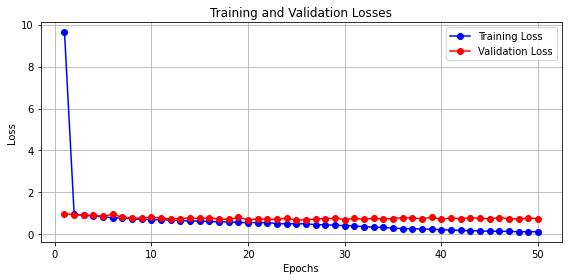

In [141]:
plot_losses(train_losses, valid_losses, title=f"Training and Validation Losses")

In [136]:
def evaluate_model(model, dataloader, threshold=1.0):
    model.eval()
    model = model.to(device)
    
    all_actual_labels = []
    all_predicted_labels = []

    for (pairs, actual_labels) in dataloader:
        input1, input2 = pairs[0].to(device), pairs[1].to(device)
        output1, output2 = model(input1, input2)
        euclidean_distance = F.pairwise_distance(output1, output2).cpu().detach().numpy()
        
        # If the distance is below the threshold, predict as similar (label 1.0), otherwise dissimilar (label 0.0)
        predicted_labels = (euclidean_distance < threshold).astype(float)

        all_actual_labels.extend(actual_labels.numpy())
        all_predicted_labels.extend(predicted_labels)

    accuracy = accuracy_score(all_actual_labels, all_predicted_labels)
    report = classification_report(all_actual_labels, all_predicted_labels, target_names=['Negative Pair', 'Positive Pair'])

    return accuracy, report

In [142]:
valid_accuracy, valid_report = evaluate_model(trained_model, valid_loader)
print(f"Accuracy on Validation Set: {valid_accuracy}")
print(f"Classification Report on Validation Set:\n{valid_report}")

Accuracy on Validation Set: 0.7321428571428571
Classification Report on Validation Set:
               precision    recall  f1-score   support

Negative Pair       0.72      0.77      0.74       252
Positive Pair       0.75      0.70      0.72       252

     accuracy                           0.73       504
    macro avg       0.73      0.73      0.73       504
 weighted avg       0.73      0.73      0.73       504



In [143]:
test_accuracy, test_report = evaluate_model(trained_model, test_loader)
print(f"Accuracy on Test Set: {test_accuracy}")
print(f"Classification Report on Test Set:\n{test_report}")

Accuracy on Test Set: 0.6845238095238095
Classification Report on Test Set:
               precision    recall  f1-score   support

Negative Pair       0.66      0.75      0.71       252
Positive Pair       0.71      0.62      0.66       252

     accuracy                           0.68       504
    macro avg       0.69      0.68      0.68       504
 weighted avg       0.69      0.68      0.68       504



In [144]:
def display_predictions(model, dataloader, threshold=1.0, num_pairs=5):
    model.eval()
    model = model.to(device)
    count = 0

    for (pairs, actual_labels) in dataloader:
        if count >= num_pairs:
            break

        input1, input2 = pairs[0].to(device), pairs[1].to(device)
        output1, output2 = model(input1, input2)
        euclidean_distance = F.pairwise_distance(output1, output2).cpu().detach().numpy()
        
        # If the distance is below the threshold, predict as similar (label 1.0), otherwise dissimilar (label 0.0)
        predicted_labels = (euclidean_distance < threshold).astype(float)

        for idx in range(len(predicted_labels)):
            fig, axes = plt.subplots(1, 2, figsize=(10, 5))

            # Display the two images
            axes[0].imshow(pairs[0][idx].permute(1, 2, 0))
            axes[1].imshow(pairs[1][idx].permute(1, 2, 0))

            # Setting the title with predicted and actual labels
            title = f"Predicted: {'Positive Pair' if predicted_labels[idx] == 1.0 else 'Negative Pair'} | Actual: {'Positive Pair' if actual_labels[idx] == 1.0 else 'Negative Pair'}"
            plt.suptitle(title, size=16)

            # Removing axes
            axes[0].axis('off')
            axes[1].axis('off')

            count += 1
            if count >= num_pairs:
                break
    plt.show()

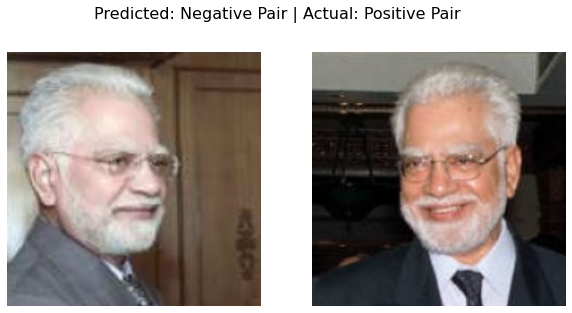

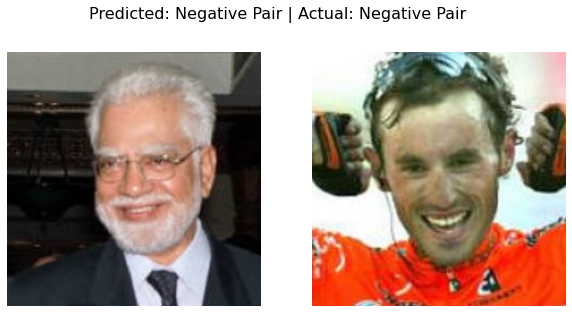

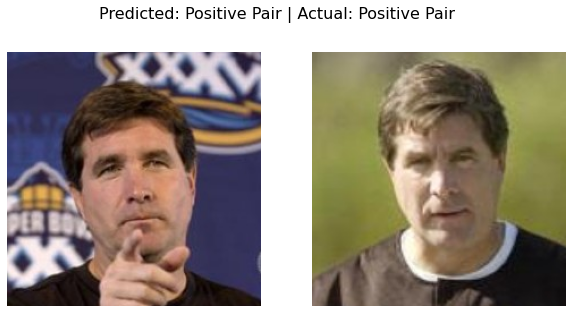

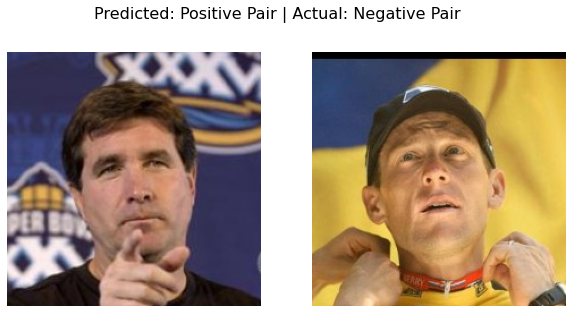

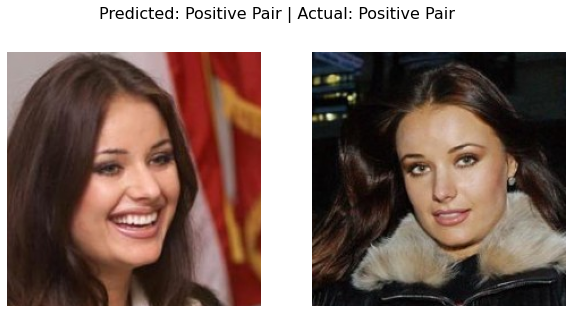

In [145]:
display_predictions(trained_model, valid_loader, threshold=1.0, num_pairs=5)

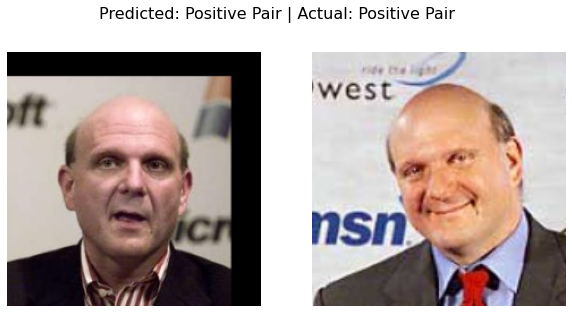

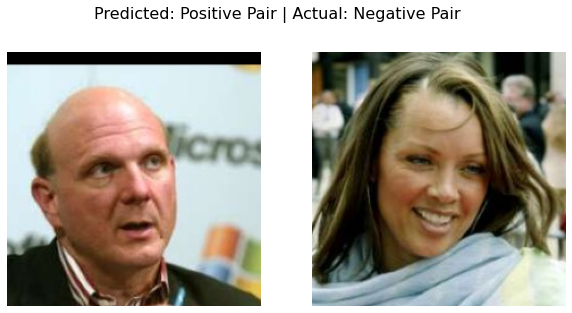

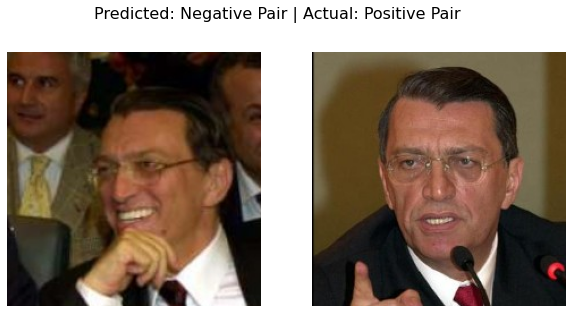

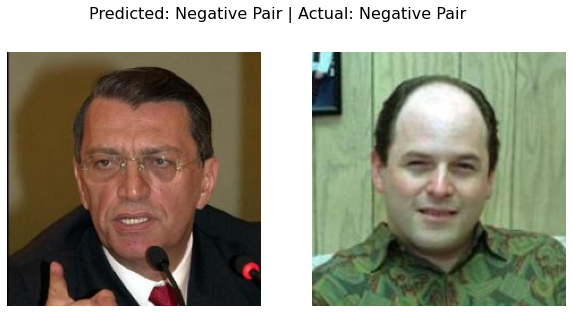

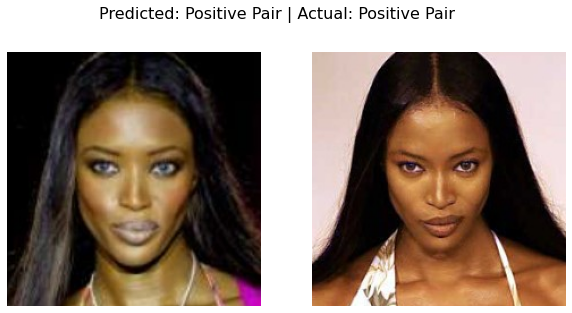

In [146]:
display_predictions(trained_model, test_loader, threshold=1.0, num_pairs=5)

### References:   <a id="references"></a>
1.  https://github.com/Mitix-EPI/Face-Recognition-using-Siamese-Networks/tree/main
2.  https://github.com/pytorch/examples/tree/main/siamese_network
3.  https://pytorch.org/vision/0.15/models.html
4.  https://chat.openai.com
5.  